# Random Forest Model:
@elivic734, @milli2908

This notebook demonstrates the workflow for building, tuning, and evaluating a Random Forest model for phage gene classification. We first illustrate our approach using an 80/20 train-test split, including parameter tuning and feature importance analysis. Afterwards, we apply the same procedure to each leave-one-out split. The model on the 80/20 split with the best accuracy and cv-score to date can be found in the first code cell. The optimized models for the leave-one-out splits are also provided in the last cell. All trained models are saved as .joblib files and the corresponding processed data, along with label encoders are stored as .pkl files under the data/RandomForest directory. Underneath you can find code we used to analize and optimize the model. The structure is as follows:

1. **80/20-Split**
    1. **Optimized Model**
    2. **Hyperparameter Tuning**
        - RandomizedSearchCV (broad search)
        - GridSearchCV (fine-tuning)
    3. **Visualization of Classification Distribution and Feature Importance**
    4. **Finding best number of Features**
5. **Leave-One-Out-Splits**
    1. **Optimized Models on each split in Leave-One-Out + Visualization**

---


In [203]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import joblib 
from sklearn.utils.class_weight import compute_sample_weight
import os
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder

## 1. Optimized Model on 80/20 split

In [204]:
# --- Data loading and preprocessing ---
train_df = pd.read_csv('../data/combined-data-stratified-split/train_data.tsv', sep='\t')
test_df = pd.read_csv('../data/combined-data-stratified-split/test_data.tsv', sep='\t')

# Create folder to store models and plots
os.makedirs("../data/RandomForest", exist_ok=True)

# Columns to drop
cols_to_drop = ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_y']

# Separate features and target variable
X_train_all_features = train_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')

X_test_all_features = test_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')

# Encode labels
le = LabelEncoder()
le.fit(["early", "middle", "late"]) 
y_train = le.fit_transform(train_df['classification_x'])
y_test = le.transform(test_df['classification_x'])


# --- Train a temporary model to get feature importances ---
rf_model_all_features = RandomForestClassifier(
    random_state=42,
    n_estimators=389,
    max_depth=13,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini',
    class_weight='balanced_subsample'
)
rf_model_all_features.fit(X_train_all_features, y_train)

# --- Select top 36 features based on importance ---
importances = rf_model_all_features.feature_importances_
feature_names = X_train_all_features.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
top36_features = feat_imp.index[:36].tolist()
print("Top 36 Features:", top36_features)

# --- Reduce datasets to top 36 features only ---
X_train = X_train_all_features[top36_features]
X_test = X_test_all_features[top36_features]

# --- Retrain model using only top 36 features ---
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=389,
    max_depth=13,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini',
    class_weight='balanced_subsample'
)
rf_model.fit(X_train, y_train)

# --- Model evaluation ---
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Cross-validation on training data
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print("CV-Score (mean):", cv_scores.mean())
print("CV-Scores (per fold):", cv_scores)

# Classification report on test data
print(classification_report(y_test, y_pred))

# save model
joblib.dump(rf_model, f"../data/RandomForest/model_split_80_20.joblib")

# save pickle
split = "80_20"
result = (X_train, y_train, X_test, y_test, le, split)
filepath = "../data/RandomForest/"
os.makedirs(os.path.dirname(filepath), exist_ok=True)
with open(f"../data/RandomForest/split_80_20_data.pkl", "wb") as f:
    pickle.dump(result, f)


Top 36 Features: ['Gene_Position_Relative', 'kmer_TGA', 'kmer_ATA', 'kmer_TTG', 'GC_Content', 'Seq_length', 'G_Content', 'C_Content', 'kmer_ACA', 'molecular_weight', 'kmer_ATG', 'kmer_TAT', 'seq_length', 'T_Content', 'kmer_GTT', 'kmer_TGG', 'kmer_TAG', 'kmer_TCT', 'kmer_CTG', 'A_Content', 'kmer_GAC', 'aromaticity', 'kmer_AAT', 'C_frac', 'kmer_CCG', 'kmer_CCC', 'kmer_AGA', 'kmer_TAA', 'kmer_GGC', 'GRAVY', 'kmer_AGC', 'kmer_TCA', 'kmer_GTA', 'kmer_CAT', 'kmer_TAC', 'kmer_CAC']
Accuracy: 0.683982683982684
CV-Score (mean): 0.6641421856639248
CV-Scores (per fold): [0.65405405 0.64324324 0.69189189 0.69021739 0.64130435]
              precision    recall  f1-score   support

           0       0.67      0.61      0.64        61
           1       0.70      0.75      0.72        92
           2       0.68      0.67      0.67        78

    accuracy                           0.68       231
   macro avg       0.68      0.67      0.68       231
weighted avg       0.68      0.68      0.68       2

## 2.1.  Hyperparameter Tuning: RandomSearchCV on 80/20 split

In [183]:
# --- Hyperparameter tuning with RandomizedSearchCV ---

param_dist = {
    'n_estimators': [50, 100, 150, 200, 300, 340, 350, 360, 400, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 35, 45],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
    'oob_score': [False, True],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print('Best parameters found:')
print(random_search.best_params_)

y_pred_best = random_search.predict(X_test)
print('Accuracy (best RF):', accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.0, class_weight=balanced, criterion=entropy, max_depth=35, max_features=log2, max_leaf_nodes=50, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=4, n_estimators=300, oob_score=False; total time=   1.9s
[CV] END bootstrap=False, ccp_alpha=0.1, class_weight=balanced, criterion=log_loss, max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0

/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
215 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/base.py", line 469, in _validate_params
    v

Best parameters found:
{'oob_score': False, 'n_estimators': 340, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0.0, 'bootstrap': False}
Accuracy (best RF): 0.6666666666666666
              precision    recall  f1-score   support

       early       0.62      0.66      0.63        61
        late       0.70      0.67      0.69        92
      middle       0.67      0.67      0.67        78

    accuracy                           0.67       231
   macro avg       0.66      0.67      0.66       231
weighted avg       0.67      0.67      0.67       231



## 2.2.  Hyperparameter Tuning: GridSearchCV on 80/20 split

In [184]:
# --- Hyperparameter tuning with GridSearchCV ---

param_grid = {
    'n_estimators': [389],
    'max_depth': [13],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'criterion': ['gini'],
    'class_weight': ['balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='balanced_accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best CV score:', grid_search.best_score_)

y_pred_grid = grid_search.predict(X_test)
print('Test set accuracy:', accuracy_score(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   1.8s
Best parameters:

## 3. Visualization of Feature Importance on 80/20 split

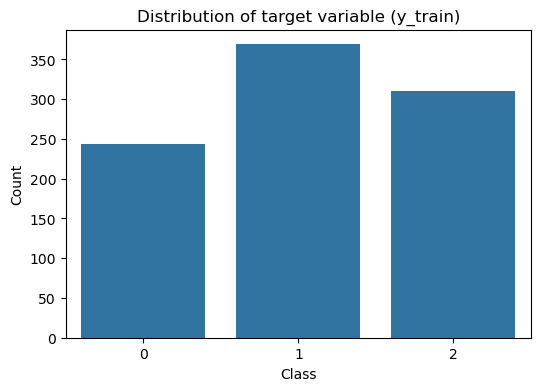

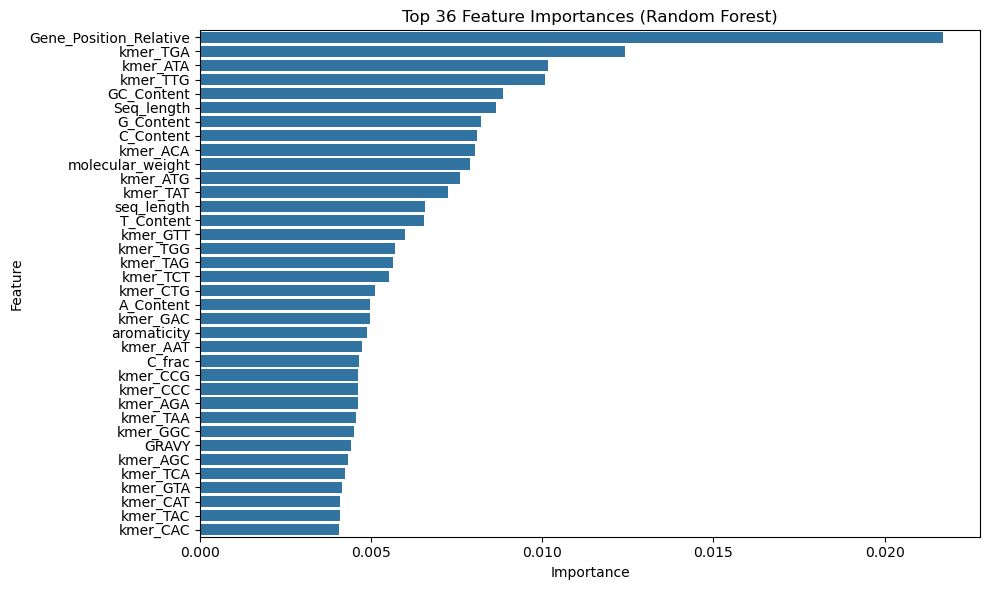

In [206]:
# --- Visualization: target distribution and feature importances ---

# Visualize target variable (y_train) distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Distribution of target variable (y_train)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Visualize feature importances (after training!)
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model_all_features.feature_importances_
    feature_names = X_train_all_features.columns
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.values[:36], y=feat_imp.index[:36])
    plt.title('Top 36 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('Feature importances not available for this model.')


## 4. Finding best number of Features on 80/20 split

In [187]:
# --- Feature number optimization: loop over top-n features ---
results = []
for n in range(1, 86):  # 1 to 86
    # Choose top-n features
    topn_features = feat_imp.index[:n].tolist()
    X_train_n = X_train_all_features[topn_features]
    X_test_n = X_test_all_features[topn_features]
    
    # GridSearchCV
    param_grid = {
        'n_estimators': [389],
        'max_depth': [13],
        'min_samples_split': [5],
        'min_samples_leaf': [1],
        'max_features': ['sqrt'],
        'bootstrap': [True],
        'criterion': ['gini'],
        'class_weight': ['balanced_subsample']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='balanced_accuracy', 
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_n, y_train)
    score = grid_search.best_score_
    results.append({'n_features': n, 'cv_score': score, 'params': grid_search.best_params_})
    print(f"Top {n} Features: CV-Score = {score:.3f}")

# Show results as DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criterion=gini, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=389; total time=   0.7s
Top 1 Features: 

## 5. Optimized models on Leave-One-Out splits


=== Processing Split 0 ===


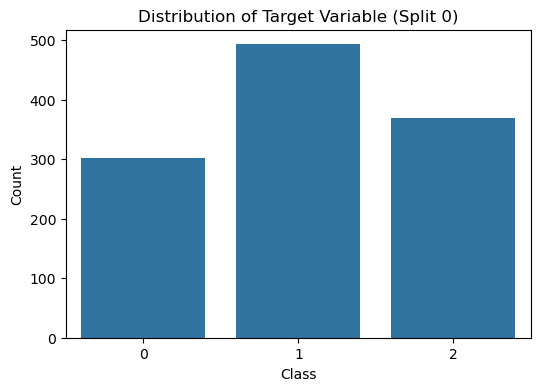

Top 8 features: CV balanced accuracy = 0.4558
Top 9 features: CV balanced accuracy = 0.4532
Top 10 features: CV balanced accuracy = 0.4625
Top 11 features: CV balanced accuracy = 0.4908
Top 12 features: CV balanced accuracy = 0.4865
Top 13 features: CV balanced accuracy = 0.5012
Top 14 features: CV balanced accuracy = 0.5069
Top 15 features: CV balanced accuracy = 0.5060
Top 16 features: CV balanced accuracy = 0.4980
Top 17 features: CV balanced accuracy = 0.5108
Top 18 features: CV balanced accuracy = 0.5070
Top 19 features: CV balanced accuracy = 0.5124
Top 20 features: CV balanced accuracy = 0.5030
Top 21 features: CV balanced accuracy = 0.5142
Top 22 features: CV balanced accuracy = 0.5130
Top 23 features: CV balanced accuracy = 0.5118
Top 24 features: CV balanced accuracy = 0.5102
Top 25 features: CV balanced accuracy = 0.5170
Top 26 features: CV balanced accuracy = 0.5134
Top 27 features: CV balanced accuracy = 0.5266
Top 28 features: CV balanced accuracy = 0.5203
Top 29 features

/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

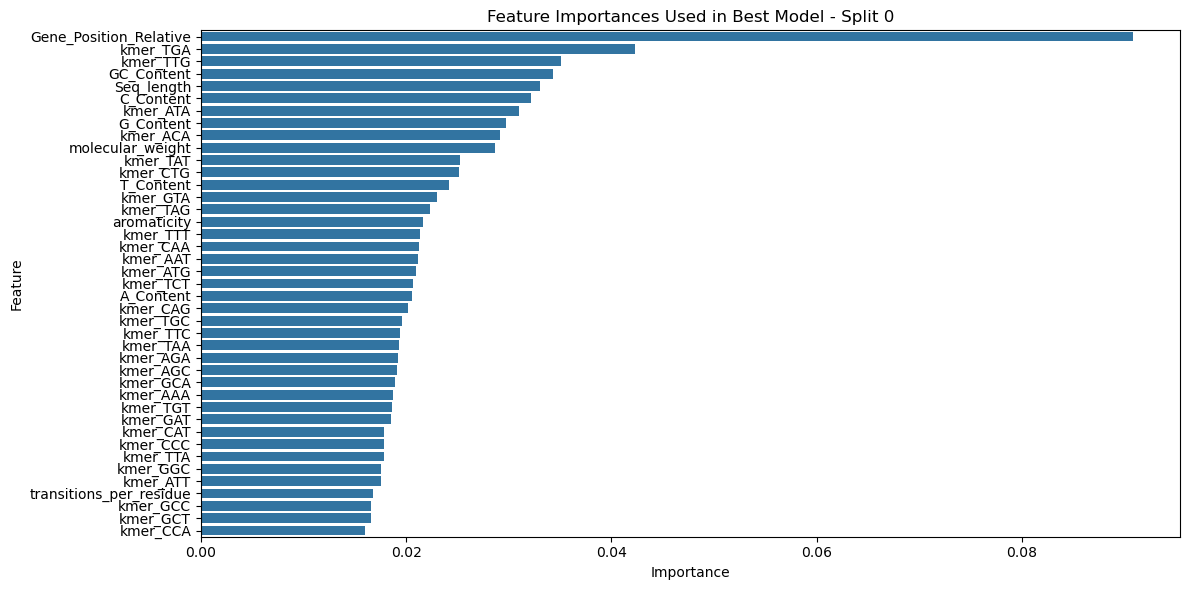


=== Processing Split 1 ===


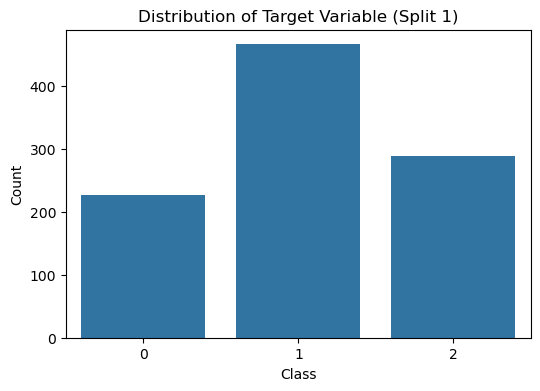

Top 8 features: CV balanced accuracy = 0.4744
Top 9 features: CV balanced accuracy = 0.4612
Top 10 features: CV balanced accuracy = 0.4477
Top 11 features: CV balanced accuracy = 0.4653
Top 12 features: CV balanced accuracy = 0.4609
Top 13 features: CV balanced accuracy = 0.4642
Top 14 features: CV balanced accuracy = 0.4815
Top 15 features: CV balanced accuracy = 0.4744
Top 16 features: CV balanced accuracy = 0.4584
Top 17 features: CV balanced accuracy = 0.4653
Top 18 features: CV balanced accuracy = 0.4709
Top 19 features: CV balanced accuracy = 0.4806
Top 20 features: CV balanced accuracy = 0.4908
Top 21 features: CV balanced accuracy = 0.4889
Top 22 features: CV balanced accuracy = 0.4912
Top 23 features: CV balanced accuracy = 0.4878
Top 24 features: CV balanced accuracy = 0.4931
Top 25 features: CV balanced accuracy = 0.4841
Top 26 features: CV balanced accuracy = 0.4899
Top 27 features: CV balanced accuracy = 0.4807
Top 28 features: CV balanced accuracy = 0.4880
Top 29 features

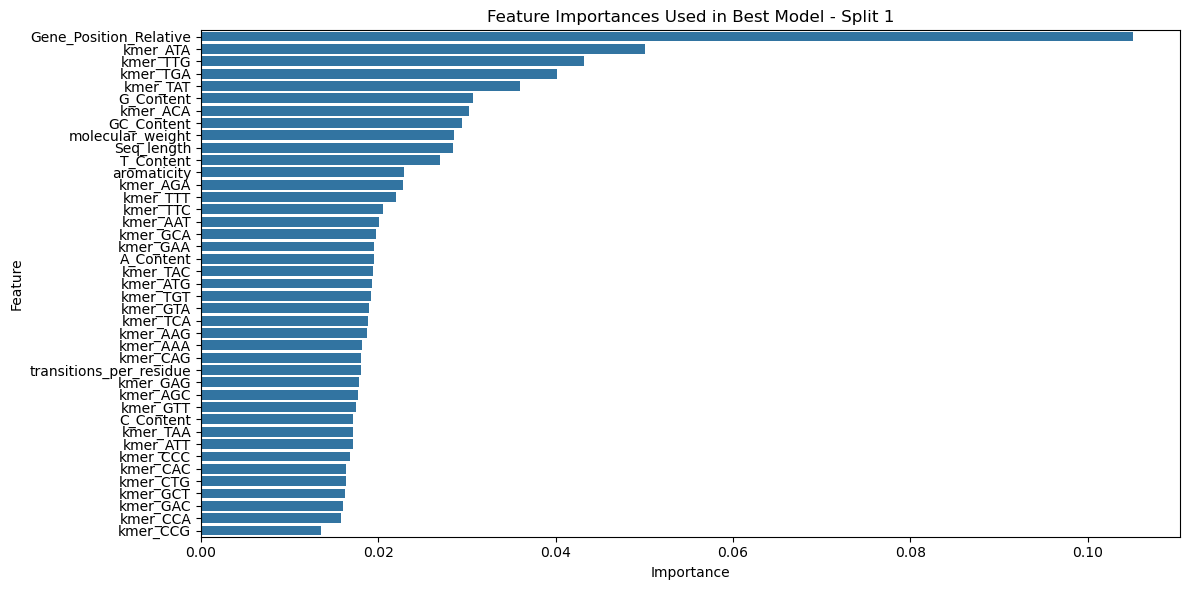


=== Processing Split 2 ===


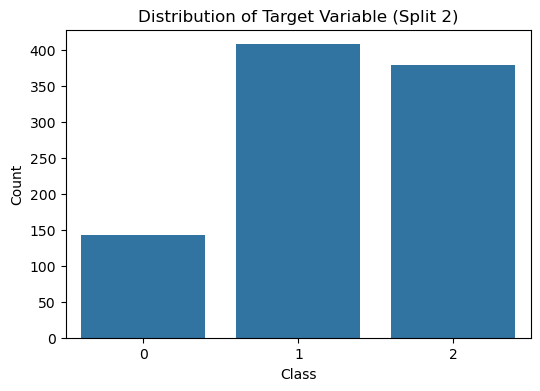

Top 8 features: CV balanced accuracy = 0.4869
Top 9 features: CV balanced accuracy = 0.4662
Top 10 features: CV balanced accuracy = 0.4692
Top 11 features: CV balanced accuracy = 0.4780
Top 12 features: CV balanced accuracy = 0.4613
Top 13 features: CV balanced accuracy = 0.4711
Top 14 features: CV balanced accuracy = 0.4697
Top 15 features: CV balanced accuracy = 0.4667
Top 16 features: CV balanced accuracy = 0.4724
Top 17 features: CV balanced accuracy = 0.4795
Top 18 features: CV balanced accuracy = 0.4746
Top 19 features: CV balanced accuracy = 0.4701
Top 20 features: CV balanced accuracy = 0.4836
Top 21 features: CV balanced accuracy = 0.4775
Top 22 features: CV balanced accuracy = 0.4845
Top 23 features: CV balanced accuracy = 0.4949
Top 24 features: CV balanced accuracy = 0.4869
Top 25 features: CV balanced accuracy = 0.4854
Top 26 features: CV balanced accuracy = 0.4810
Top 27 features: CV balanced accuracy = 0.4923
Top 28 features: CV balanced accuracy = 0.4832
Top 29 features

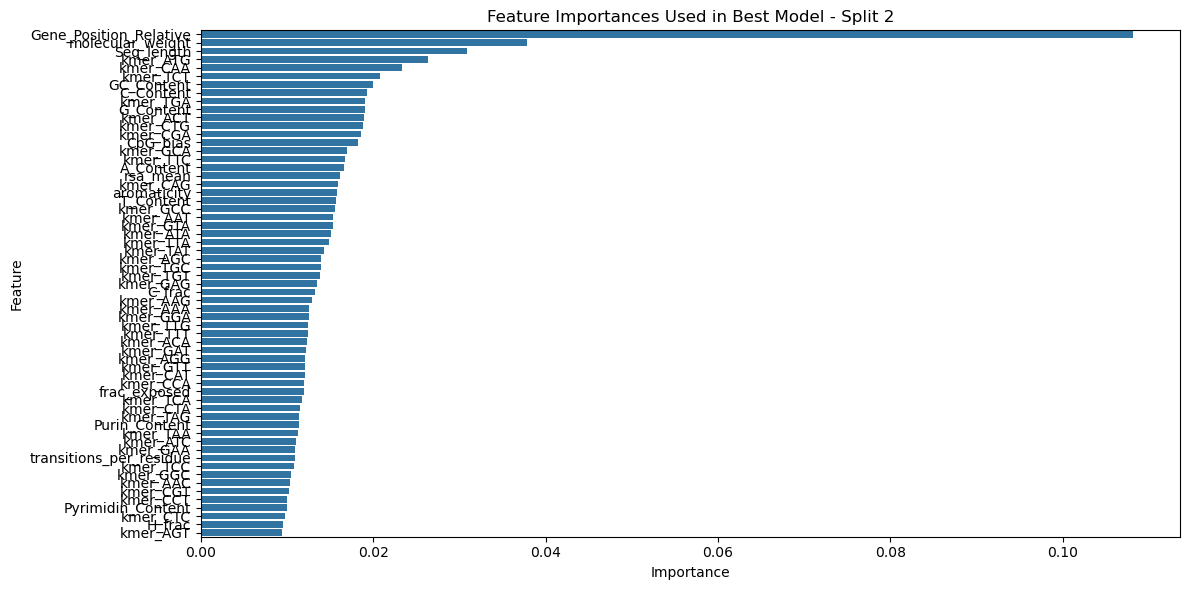


=== Processing Split 3 ===


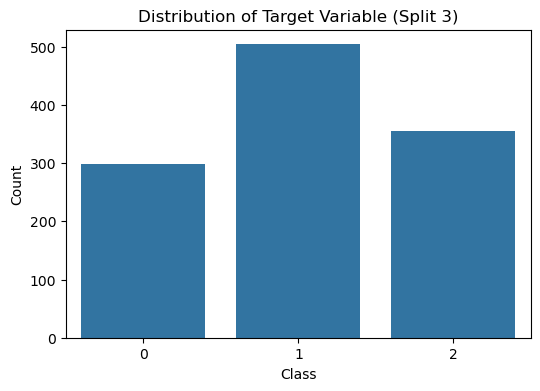

Top 8 features: CV balanced accuracy = 0.5001
Top 9 features: CV balanced accuracy = 0.5053
Top 10 features: CV balanced accuracy = 0.5109
Top 11 features: CV balanced accuracy = 0.5122
Top 12 features: CV balanced accuracy = 0.5227
Top 13 features: CV balanced accuracy = 0.5195
Top 14 features: CV balanced accuracy = 0.5322
Top 15 features: CV balanced accuracy = 0.5268
Top 16 features: CV balanced accuracy = 0.5361
Top 17 features: CV balanced accuracy = 0.5276
Top 18 features: CV balanced accuracy = 0.5305
Top 19 features: CV balanced accuracy = 0.5329
Top 20 features: CV balanced accuracy = 0.5394
Top 21 features: CV balanced accuracy = 0.5337
Top 22 features: CV balanced accuracy = 0.5413
Top 23 features: CV balanced accuracy = 0.5400
Top 24 features: CV balanced accuracy = 0.5444
Top 25 features: CV balanced accuracy = 0.5286
Top 26 features: CV balanced accuracy = 0.5439
Top 27 features: CV balanced accuracy = 0.5350
Top 28 features: CV balanced accuracy = 0.5378
Top 29 features

/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

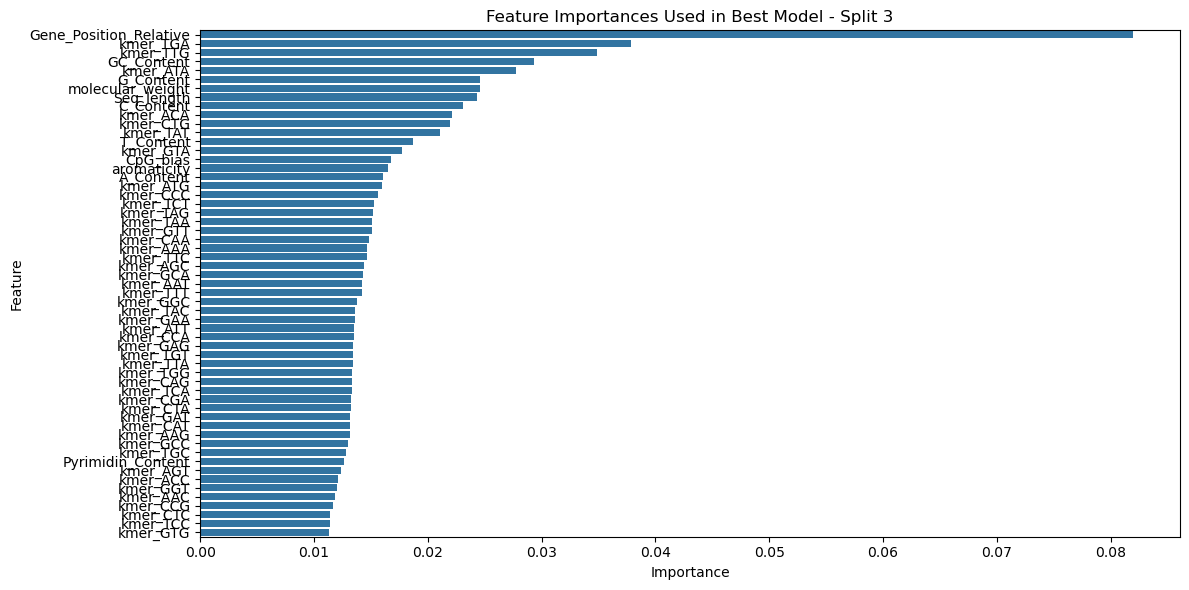


=== Processing Split 4 ===


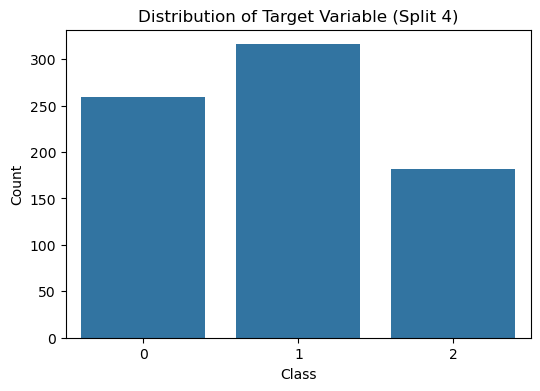

Top 8 features: CV balanced accuracy = 0.4845
Top 9 features: CV balanced accuracy = 0.4975
Top 10 features: CV balanced accuracy = 0.5183
Top 11 features: CV balanced accuracy = 0.4975
Top 12 features: CV balanced accuracy = 0.5037
Top 13 features: CV balanced accuracy = 0.5045
Top 14 features: CV balanced accuracy = 0.5098
Top 15 features: CV balanced accuracy = 0.5030
Top 16 features: CV balanced accuracy = 0.4949
Top 17 features: CV balanced accuracy = 0.4987
Top 18 features: CV balanced accuracy = 0.5103
Top 19 features: CV balanced accuracy = 0.5165
Top 20 features: CV balanced accuracy = 0.5245
Top 21 features: CV balanced accuracy = 0.5207
Top 22 features: CV balanced accuracy = 0.5189
Top 23 features: CV balanced accuracy = 0.5118
Top 24 features: CV balanced accuracy = 0.5157
Top 25 features: CV balanced accuracy = 0.5162
Top 26 features: CV balanced accuracy = 0.5129
Top 27 features: CV balanced accuracy = 0.5174
Top 28 features: CV balanced accuracy = 0.5153
Top 29 features

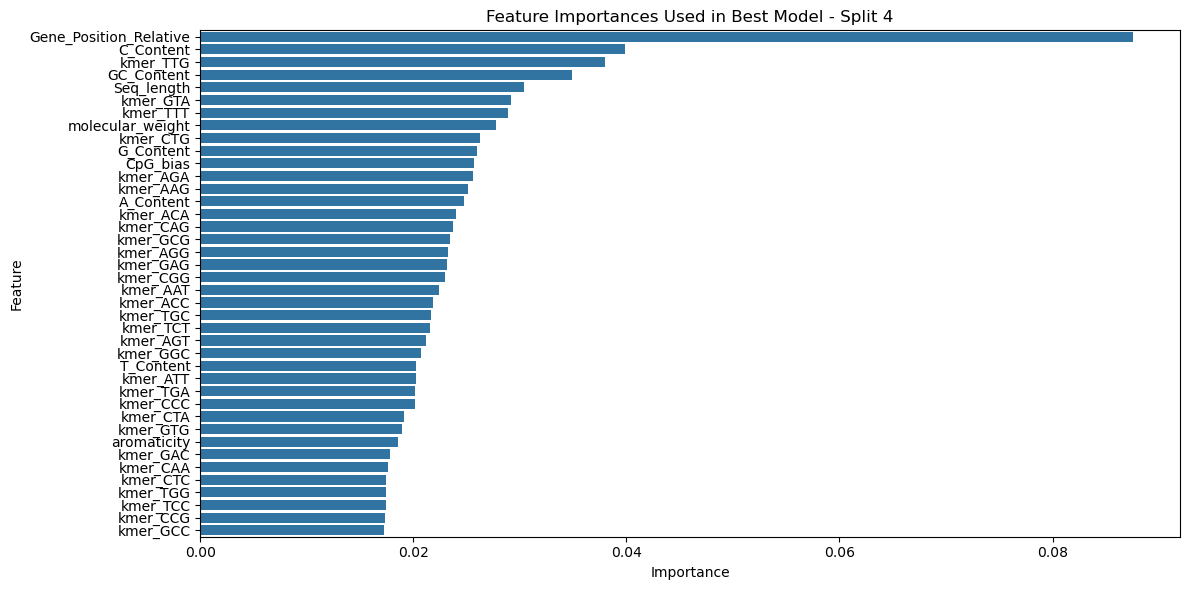


=== Processing Split 5 ===


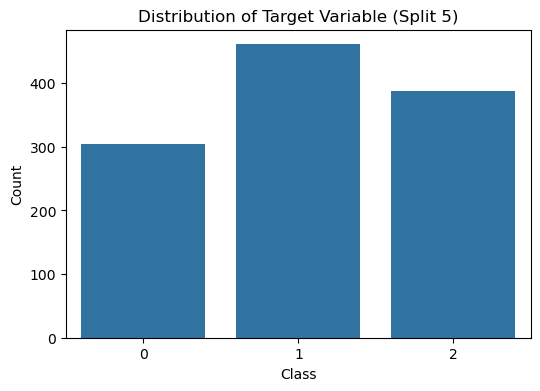

Top 8 features: CV balanced accuracy = 0.4531
Top 9 features: CV balanced accuracy = 0.4445
Top 10 features: CV balanced accuracy = 0.4459
Top 11 features: CV balanced accuracy = 0.4557
Top 12 features: CV balanced accuracy = 0.4649
Top 13 features: CV balanced accuracy = 0.4682
Top 14 features: CV balanced accuracy = 0.4888
Top 15 features: CV balanced accuracy = 0.4870
Top 16 features: CV balanced accuracy = 0.4897
Top 17 features: CV balanced accuracy = 0.4962
Top 18 features: CV balanced accuracy = 0.4799
Top 19 features: CV balanced accuracy = 0.4895
Top 20 features: CV balanced accuracy = 0.4963
Top 21 features: CV balanced accuracy = 0.4996
Top 22 features: CV balanced accuracy = 0.5128
Top 23 features: CV balanced accuracy = 0.5076
Top 24 features: CV balanced accuracy = 0.5136
Top 25 features: CV balanced accuracy = 0.5054
Top 26 features: CV balanced accuracy = 0.5060
Top 27 features: CV balanced accuracy = 0.5119
Top 28 features: CV balanced accuracy = 0.5086
Top 29 features

/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/vividVirions/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

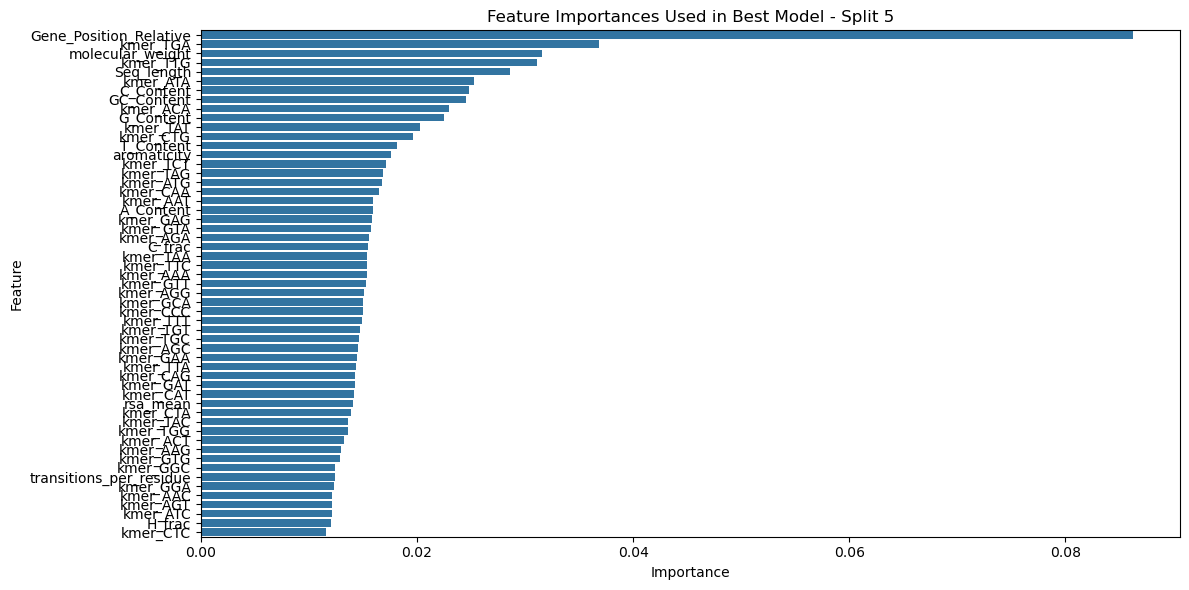


=== Processing Split 6 ===


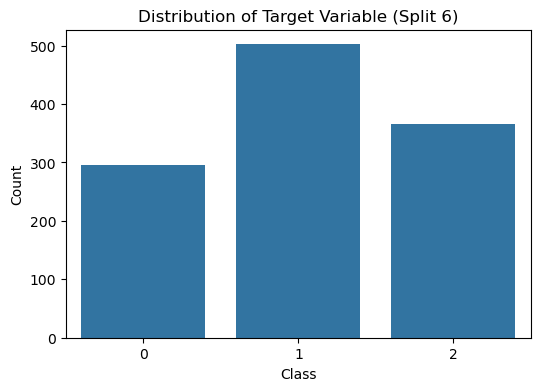

Top 8 features: CV balanced accuracy = 0.4874
Top 9 features: CV balanced accuracy = 0.4863
Top 10 features: CV balanced accuracy = 0.5027
Top 11 features: CV balanced accuracy = 0.5115
Top 12 features: CV balanced accuracy = 0.5084
Top 13 features: CV balanced accuracy = 0.5153
Top 14 features: CV balanced accuracy = 0.5180
Top 15 features: CV balanced accuracy = 0.5256
Top 16 features: CV balanced accuracy = 0.5149
Top 17 features: CV balanced accuracy = 0.5256
Top 18 features: CV balanced accuracy = 0.5286
Top 19 features: CV balanced accuracy = 0.5300
Top 20 features: CV balanced accuracy = 0.5291
Top 21 features: CV balanced accuracy = 0.5347
Top 22 features: CV balanced accuracy = 0.5410
Top 23 features: CV balanced accuracy = 0.5252
Top 24 features: CV balanced accuracy = 0.5406
Top 25 features: CV balanced accuracy = 0.5327
Top 26 features: CV balanced accuracy = 0.5398
Top 27 features: CV balanced accuracy = 0.5349
Top 28 features: CV balanced accuracy = 0.5350
Top 29 features

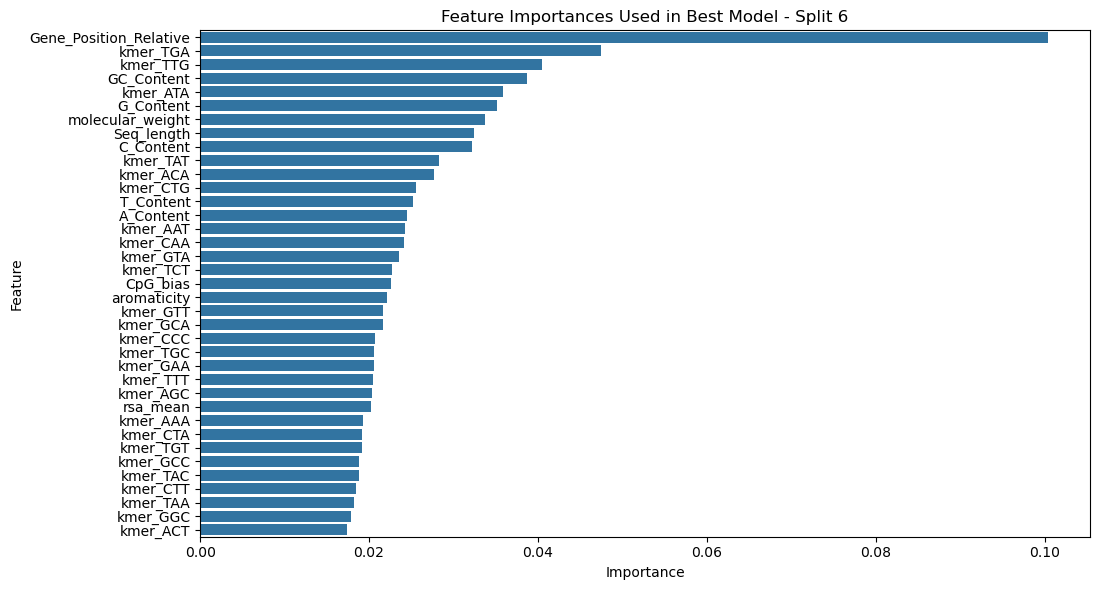

In [212]:
# --- Random Forest Model for the Leave-One-Group-Out Splits ---

# --- Configuration ---
cols_to_drop = ['Unnamed: 0', 'Geneid', 'DNASequence', 'classification_y', 'group']
param_grid = {
    'n_estimators': [389],
    'max_depth': [13],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'criterion': ['gini'],
    'class_weight': ['balanced_subsample']
}

num_splits = 7  # Adjust according to your splits count

os.makedirs("../data/RandomForest", exist_ok=True)

# --- Loop over splits ---
for split in range(num_splits):
    print(f"\n=== Processing Split {split} ===")

    # Load train and test data
    train_df = pd.read_csv(f'../data/leave-one-group-out-split/splits/train_split_{split}.tsv', sep='\t')
    test_df = pd.read_csv(f'../data/leave-one-group-out-split/splits/test_split_{split}.tsv', sep='\t')

    # Label encoding with fixed class order for consistent mapping
    le = LabelEncoder()
    le.fit(["early", "middle", "late"])
    train_df["classification_x"] = le.transform(train_df["classification_x"])
    test_df["classification_x"] = le.transform(test_df["classification_x"])

    # Separate features and target variable
    X_train_all = train_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')
    y_train = train_df['classification_x']
    X_test_all = test_df.drop(columns=cols_to_drop + ['classification_x'], errors='ignore')
    y_test = test_df['classification_x']

    # --- Visualization: Target distribution in training set ---
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_train)
    plt.title(f'Distribution of Target Variable (Split {split})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    # Train initial Random Forest to get feature importances
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_all, y_train)

    importances = rf_model.feature_importances_
    feature_names = X_train_all.columns
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    # Limit search to between 10% and 90% of total features
    n_features = len(feat_imp)
    start_idx = max(1, int(n_features * 0.10))
    end_idx = max(start_idx + 1, int(n_features * 0.90))

    best_score = 0
    best_model = None
    best_n = 0

    # Feature number optimization loop
    for n in range(start_idx, end_idx + 1):
        top_features = feat_imp.index[:n].tolist()

        X_train_n = X_train_all[top_features]

        grid_search = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_grid=param_grid,
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train_n, y_train)
        score = grid_search.best_score_

        print(f"Top {n} features: CV balanced accuracy = {score:.4f}")

        if score > best_score:
            best_score = score
            best_model = grid_search.best_estimator_
            best_n = n
    print(f"Best number of features for split {split}: {best_n}")        

    # Final evaluation on test set with best model and features
    top_features = feat_imp.index[:best_n].tolist()
    best_model.fit(X_train_all[top_features], y_train)
    y_pred = best_model.predict(X_test_all[top_features])

    # Print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nSplit {split} Results:")
    print(f"Accuracy: {accuracy:.6f}")

    cv_scores = cross_val_score(best_model, X_train_all[top_features], y_train, cv=5, scoring='accuracy')
    print(f"CV-Score (mean): {cv_scores.mean():.6f}")
    print(f"CV-Scores (per fold): {list(cv_scores)}")

    print(classification_report(y_test, y_pred))

    # --- Visualization: Feature importances from the best model ---
    if hasattr(best_model, 'feature_importances_'):
        best_importances = best_model.feature_importances_
        best_feat_imp = pd.Series(best_importances, index=top_features).sort_values(ascending=False)

        plt.figure(figsize=(min(12, 0.3 * len(best_feat_imp)), 6))  # dynamic width
        sns.barplot(x=best_feat_imp.values, y=best_feat_imp.index)
        plt.title(f'Feature Importances Used in Best Model - Split {split}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    else:
        print('Feature importances not available for the best model.')

    # Save best model
    model_path = f"../data/RandomForest/model_split_{split}.joblib"
    joblib.dump(best_model, model_path)

    # Save processed data and encoder
    data_path = f"../data/RandomForest/split_{split}_data.pkl"
    with open(data_path, "wb") as f:
        pickle.dump((X_train_all[top_features], y_train, X_test_all[top_features], y_test, le, split), f)
